In [1]:
import datasets
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import plotly
nltk.download('punkt')
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import optuna.visualization
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

[nltk_data] Downloading package punkt to /home/egor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Решил взять датасет новостей из телеграмм каналов про финансы, период составления датасета неизвестен 

In [2]:
dataset = datasets.load_dataset("mxlcw/telegram-financial-sentiment-summarization", split='train')

dataset.shape

(18107, 8)

In [3]:
data = dataset.to_pandas()
data.head()

,date,post_url,text,summarized_text,regular_text_sentiment_label,regular_text_sentiment_score,summarized_text_sentiment_label,summarized_text_sentiment_score
0,2023-01-10 16:19:00,https://t.me/tinkoff_analytics_official/483/?e...,​​Спрос на морские перевозки падает — как это ...,Спрос на морские перевозки из Азии в США упал ...,negative,0.839419,negative,0.962864
1,2023-01-11 15:04:00,https://t.me/tinkoff_analytics_official/484/?e...,Новое бюджетное правило в действии \nС 13 янв...,Банк России возобновит операции с иностранной ...,neutral,0.539706,neutral,0.656357
2,2023-01-12 18:13:00,https://t.me/tinkoff_analytics_official/485/?e...,Ожидаемое замедление инфляции в США \nВ дека...,Ожидаемое замедление инфляции в США замедлилос...,negative,0.737480,negative,0.787353
3,2023-01-16 17:16:00,https://t.me/tinkoff_analytics_official/486/?e...,Главными событиями прошлой недели стали возвра...,Вслед за возвращением бюджетного правила в Рос...,positive,0.805179,positive,0.594537
4,2023-01-17 17:25:00,https://t.me/tinkoff_analytics_official/489/?e...,​​Сбер: рост прибыли ускоряется \nрекомендаци...,Сбер зафиксировал годовой обвал прибыли на 40%...,positive,0.919446,negative,0.534806


# 1. Предварительная обработка текстов

В этом разделе производится лемматизация и очистка текстов с помощью spacy

Каждое сообщение преобразуется к списку лемм, удаляются стоп-слова (кроме 'не')

In [4]:
import spacy
from tqdm import tqdm
nlp = spacy.load('ru_core_news_sm')

def preprocess(text):
    doc = nlp(str(text))
    tokens = [
        token.lemma_.lower()
        for token in doc
        if (token.is_alpha and (not token.is_stop or token.text.lower() == 'не'))
    ]
    return ' '.join(tokens)

tqdm.pandas(desc='Обработка текстов')
data['preprocessed_text'] = data['text'].progress_apply(preprocess)
data[['text', 'preprocessed_text']].head()

Обработка текстов: 100%|██████████| 18107/18107 [07:27<00:00, 40.50it/s]


,text,preprocessed_text
0,​​Спрос на морские перевозки падает — как это ...,морской перевозка падать повлиять мировой экон...
1,Новое бюджетное правило в действии \nС 13 янв...,новый бюджетный правило действие январь банк р...
2,Ожидаемое замедление инфляции в США \nВ дека...,ожидать замедление инфляция сша декабрь годово...
3,Главными событиями прошлой недели стали возвра...,главный событие прошлый неделя возвращение бюд...
4,​​Сбер: рост прибыли ускоряется \nрекомендаци...,рост прибыль ускоряться рекомендация покупать ...


# 2. Анализ категорий и структуры данных

Посмотрим как классы распределены

Категории: ['negative' 'neutral' 'positive']
Количество категорий: 3
Распределение по категориям:
regular_text_sentiment_label
positive    7876
neutral     7337
negative    2894
Name: count, dtype: int64


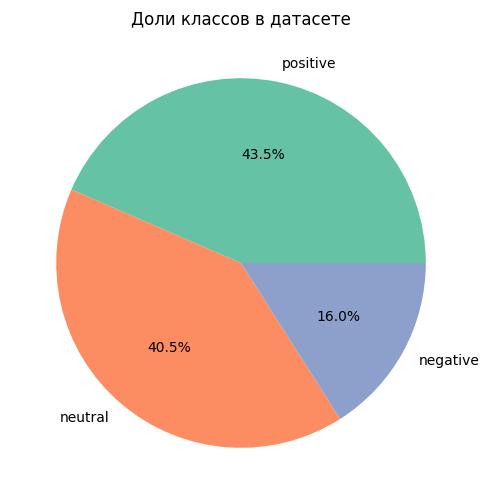

In [5]:
# Сколько и каких категорий есть в наборе
labels = data['regular_text_sentiment_label']
print('Категории:', labels.unique())
print('Количество категорий:', labels.nunique())
print('Распределение по категориям:')
print(labels.value_counts())

stats = labels.value_counts().reset_index()
stats.columns = ['Категория', 'Количество']
plt.figure(figsize=(6,6))
plt.pie(stats['Количество'], labels=stats['Категория'], autopct='%1.1f%%', colors=plt.cm.Set2.colors)
plt.title('Доли классов в датасете')
plt.show()

Считается среднее количество слов и уникальных слов в каждом сообщении.

Посмотрим на длину предложений

In [6]:
data['tokens'] = data['preprocessed_text'].apply(lambda x: word_tokenize(str(x)))
data['num_words'] = data['tokens'].apply(len)
data['num_unique_words'] = data['tokens'].apply(lambda x: len(set(x)))

print('Среднее количество слов:', data['num_words'].mean())
print('Среднее количество уникальных слов:', data['num_unique_words'].mean())

Среднее количество слов: 50.41116695200751
Среднее количество уникальных слов: 38.48815375269233


# 3. Визуализация частотности слов

В этом разделе строятся облака слов и гистограммы для всего набора и для отдельных классов.

Немного наблюдений за облаками слов:
- компания, год, ценный бумага, мск, сша, чистый прибыль - в целом логично
- brent live - не подумал что могут попасться английские слова
- шпион рцб, заметить шпион - это уже интресно 


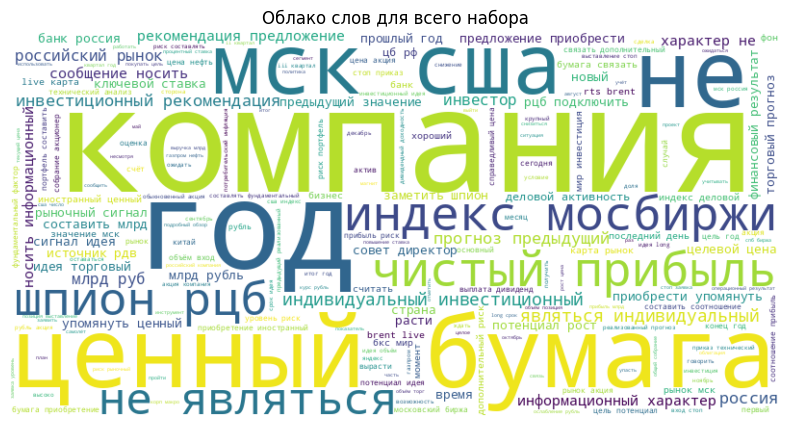

In [7]:


# Облако слов для всего набора
all_words = ' '.join([' '.join(tokens) for tokens in data['tokens']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для всего набора')
plt.show()

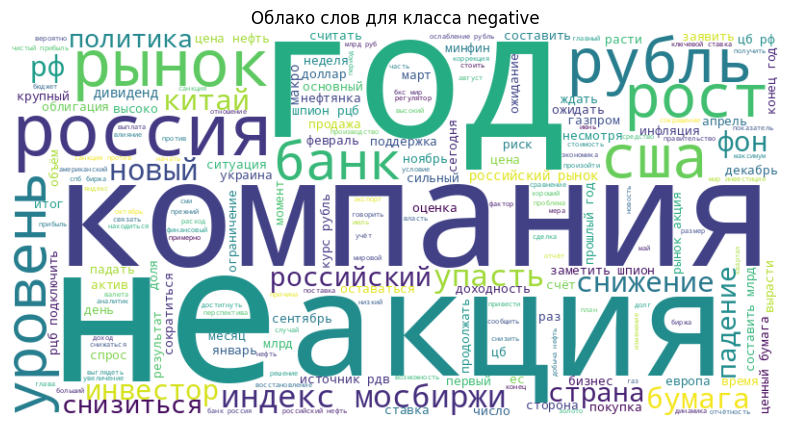

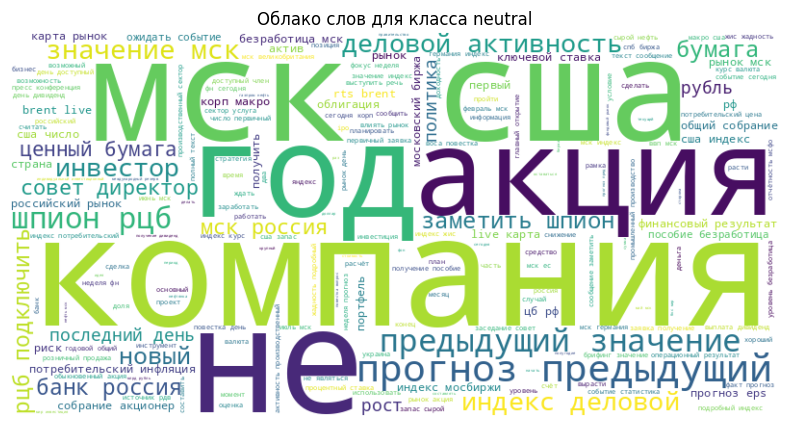

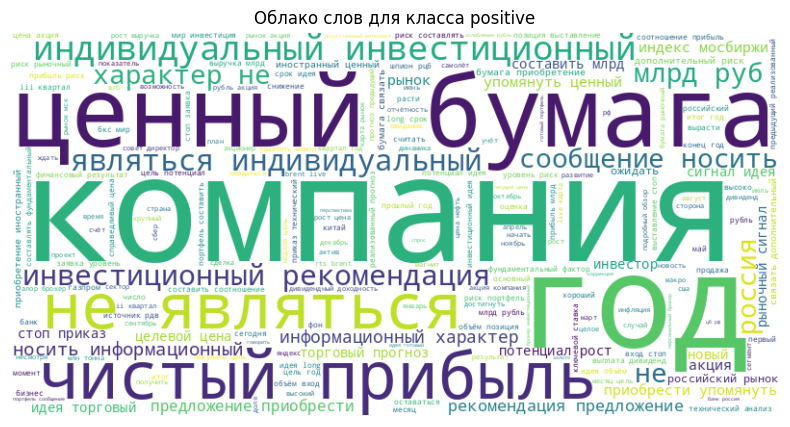

In [8]:
# Облака слов для разных классов
for label in data['regular_text_sentiment_label'].unique():
    words = ' '.join([' '.join(tokens) for tokens in data[data['regular_text_sentiment_label'] == label]['tokens']])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Облако слов для класса {label}')
    plt.show()

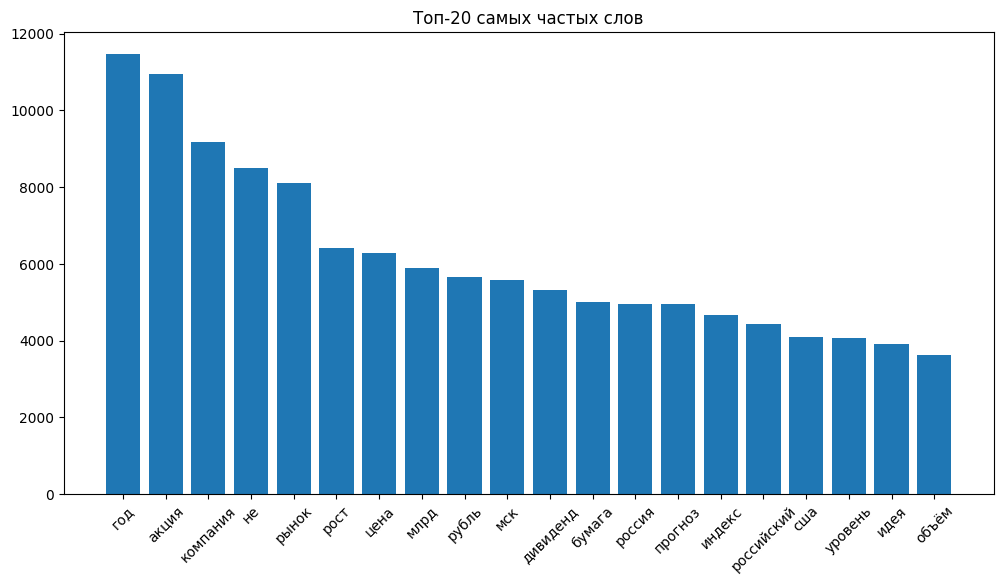

In [9]:
# Гистограмма встречаемости слов (топ-20) для всего набора
all_tokens = [token for tokens in data['tokens'] for token in tokens]
counter = Counter(all_tokens)
common_words = counter.most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Топ-20 самых частых слов')
plt.show()

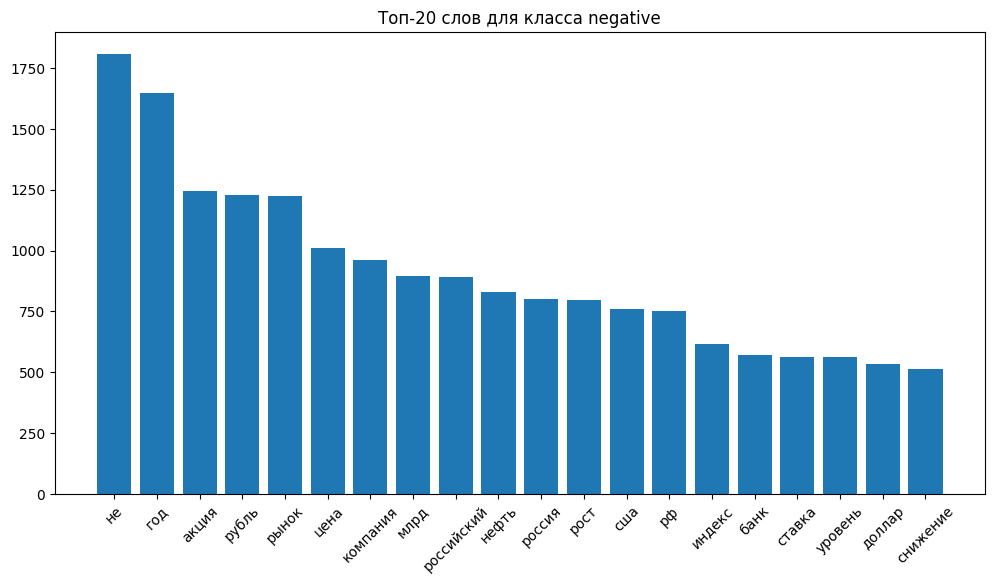

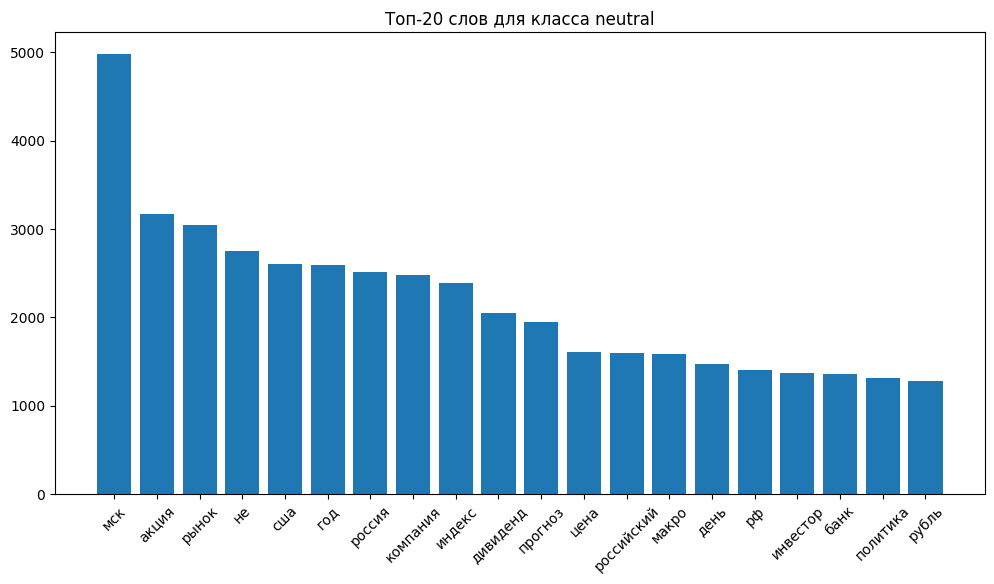

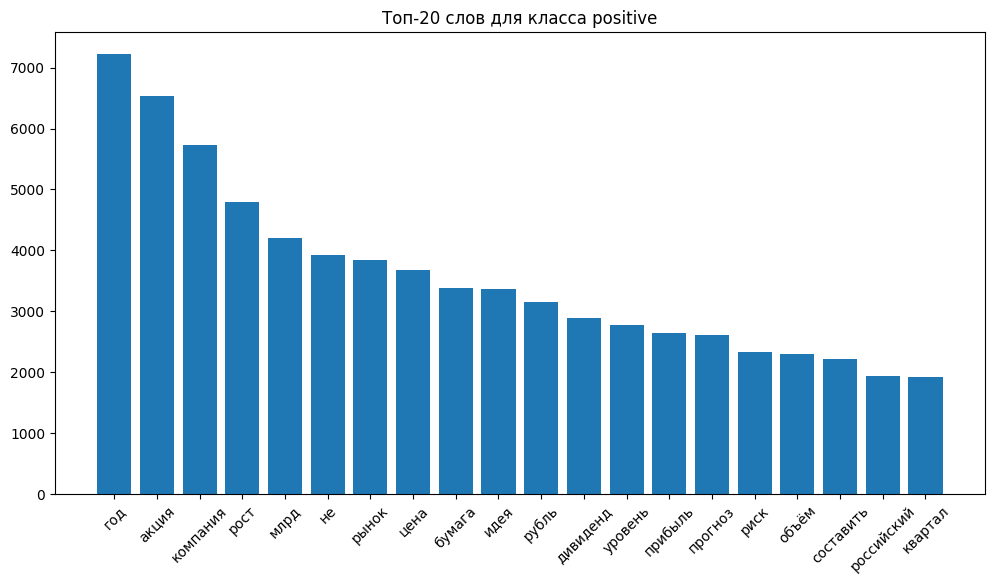

In [10]:
# Гистограммы для разных классов
for label in data['regular_text_sentiment_label'].unique():
    tokens = [token for tokens in data[data['regular_text_sentiment_label'] == label]['tokens'] for token in tokens]
    counter = Counter(tokens)
    common_words = counter.most_common(20)
    words, counts = zip(*common_words)
    plt.figure(figsize=(12,6))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f'Топ-20 слов для класса {label}')
    plt.show()

С гистограммами все ок, ничего удивительного

# 4. Обучение моделей

Здесь начинается этап построения моделей классификации.

Используются LogisticRegression и RandomForest с подбором гиперпараметров через Optuna.

Список гиперпараметров для отбора

**Для TfidfVectorizer:**
- `max_features`: максимальное число признаков (слов), влияет на размерность признакового пространства и скорость обучения.
- `ngram_range`: диапазон n-грамм (например, только слова или слова + биграммы), позволяет учитывать контекст.
- `min_df`: минимальное число документов для слова, фильтрует редкие слова.
- `max_df`: максимальная доля документов для слова, фильтрует слишком частые слова (например, стоп-слова).
- `sublinear_tf`: использовать ли сублинейное масштабирование term frequency.
- `use_idf`: использовать ли взвешивание по обратной частоте документа.

**Для LogisticRegression:**
- `penalty`: тип регуляризации (`l1` или `l2`), помогает избежать переобучения.
- `C`: коэффициент регуляризации, контролирует силу регуляризации.

**Для RandomForestClassifier:**
- `n_estimators`: количество деревьев, влияет на качество и стабильность модели.
- `max_depth`: максимальная глубина дерева, ограничивает сложность.
- `min_samples_split`: минимальное число образцов для разбиения узла.
- `min_samples_leaf`: минимальное число образцов в листе.
- `bootstrap`: использовать ли бутстрэппинг для построения деревьев.

In [11]:
# Стратифицированное разделение по классам
X = data['preprocessed_text']
y = data['regular_text_sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

ngram_map = {"1-1": (1,1), "1-2": (1,2)}

In [12]:
# Optuna + обучение LogisticRegression
def objective_lr(trial):
    max_features = trial.suggest_int("max_features", 1000, 10000)
    ngram_range = trial.suggest_categorical("ngram_range", ["1-1", "1-2"])
    min_df = trial.suggest_int("min_df", 1, 10)
    max_df = trial.suggest_float("max_df", 0.5, 1.0)
    sublinear_tf = trial.suggest_categorical("sublinear_tf", [True, False])
    use_idf = trial.suggest_categorical("use_idf", [True, False])
    penalty = trial.suggest_categorical("penalty", ["l2", "l1"])
    C = trial.suggest_float("C", 0.01, 10.0, log=True)
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_map[ngram_range],
        min_df=min_df,
        max_df=max_df,
        sublinear_tf=sublinear_tf,
        use_idf=use_idf
    )
    X_vec = vectorizer.fit_transform(X_train)
    clf = LogisticRegression(C=C, max_iter=1000, penalty=penalty, solver="saga")
    score = cross_val_score(clf, X_vec, y_train, cv=3, scoring="accuracy").mean()
    return score

study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_lr, n_trials=20, show_progress_bar=True)
print("Лучшие параметры LogisticRegression:", study_lr.best_params)

vectorizer_lr = TfidfVectorizer(
    max_features=study_lr.best_params["max_features"],
    ngram_range=ngram_map[study_lr.best_params["ngram_range"]],
    min_df=study_lr.best_params["min_df"],
    max_df=study_lr.best_params["max_df"],
    sublinear_tf=study_lr.best_params["sublinear_tf"],
    use_idf=study_lr.best_params["use_idf"]
)
X_train_vec_lr = vectorizer_lr.fit_transform(X_train)
X_test_vec_lr = vectorizer_lr.transform(X_test)
clf_lr = LogisticRegression(
    C=study_lr.best_params["C"],
    max_iter=1000,
    penalty=study_lr.best_params["penalty"],
    solver="saga"
)
clf_lr.fit(X_train_vec_lr, y_train)
y_pred_lr = clf_lr.predict(X_test_vec_lr)
print("Точность LogisticRegression:", accuracy_score(y_test, y_pred_lr))

[I 2025-10-25 18:09:12,682] A new study created in memory with name: no-name-20e04bdf-212a-424b-885a-b7b7e5a0c048


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-25 18:09:14,933] Trial 0 finished with value: 0.7463579894987986 and parameters: {'max_features': 5569, 'ngram_range': '1-2', 'min_df': 6, 'max_df': 0.544779249337326, 'sublinear_tf': False, 'use_idf': True, 'penalty': 'l2', 'C': 3.5261148201306876}. Best is trial 0 with value: 0.7463579894987986.
[I 2025-10-25 18:09:17,456] Trial 1 finished with value: 0.740490116871344 and parameters: {'max_features': 3954, 'ngram_range': '1-2', 'min_df': 1, 'max_df': 0.8381816173801302, 'sublinear_tf': False, 'use_idf': True, 'penalty': 'l2', 'C': 6.914074138011419}. Best is trial 0 with value: 0.7463579894987986.
[I 2025-10-25 18:09:17,456] Trial 1 finished with value: 0.740490116871344 and parameters: {'max_features': 3954, 'ngram_range': '1-2', 'min_df': 1, 'max_df': 0.8381816173801302, 'sublinear_tf': False, 'use_idf': True, 'penalty': 'l2', 'C': 6.914074138011419}. Best is trial 0 with value: 0.7463579894987986.
[I 2025-10-25 18:09:18,590] Trial 2 finished with value: 0.7518121552168

In [13]:
# Optuna + обучение RandomForest
def objective_rf(trial):
    max_features = trial.suggest_int("max_features", 1000, 10000)
    ngram_range = trial.suggest_categorical("ngram_range", ["1-1", "1-2"])
    min_df = trial.suggest_int("min_df", 1, 10)
    max_df = trial.suggest_float("max_df", 0.5, 1.0)
    sublinear_tf = trial.suggest_categorical("sublinear_tf", [True, False])
    use_idf = trial.suggest_categorical("use_idf", [True, False])
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_map[ngram_range],
        min_df=min_df,
        max_df=max_df,
        sublinear_tf=sublinear_tf,
        use_idf=use_idf
    )
    X_vec = vectorizer.fit_transform(X_train)
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        n_jobs=-1
    )
    score = cross_val_score(clf, X_vec, y_train, cv=3, scoring="accuracy").mean()
    return score

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)
print("Лучшие параметры RandomForest:", study_rf.best_params)

vectorizer_rf = TfidfVectorizer(
    max_features=study_rf.best_params["max_features"],
    ngram_range=ngram_map[study_rf.best_params["ngram_range"]],
    min_df=study_rf.best_params["min_df"],
    max_df=study_rf.best_params["max_df"],
    sublinear_tf=study_rf.best_params["sublinear_tf"],
    use_idf=study_rf.best_params["use_idf"]
)
X_train_vec_rf = vectorizer_rf.fit_transform(X_train)
X_test_vec_rf = vectorizer_rf.transform(X_test)
clf_rf = RandomForestClassifier(
    n_estimators=study_rf.best_params["n_estimators"],
    max_depth=study_rf.best_params["max_depth"],
    min_samples_split=study_rf.best_params["min_samples_split"],
    min_samples_leaf=study_rf.best_params["min_samples_leaf"],
    bootstrap=study_rf.best_params["bootstrap"],
    n_jobs=-1
)
clf_rf.fit(X_train_vec_rf, y_train)
y_pred_rf = clf_rf.predict(X_test_vec_rf)
print("Точность RandomForest:", accuracy_score(y_test, y_pred_rf))

[I 2025-10-25 18:09:54,106] A new study created in memory with name: no-name-ad8c5ec1-3757-4365-85cf-129e76caeb0b


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-25 18:09:57,751] Trial 0 finished with value: 0.6420428417123852 and parameters: {'max_features': 9637, 'ngram_range': '1-2', 'min_df': 2, 'max_df': 0.8907669767077728, 'sublinear_tf': False, 'use_idf': False, 'n_estimators': 204, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.6420428417123852.
[I 2025-10-25 18:10:02,517] Trial 1 finished with value: 0.6762160532578161 and parameters: {'max_features': 1465, 'ngram_range': '1-1', 'min_df': 1, 'max_df': 0.9829733592911731, 'sublinear_tf': True, 'use_idf': True, 'n_estimators': 210, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 1 with value: 0.6762160532578161.
[I 2025-10-25 18:10:02,517] Trial 1 finished with value: 0.6762160532578161 and parameters: {'max_features': 1465, 'ngram_range': '1-1', 'min_df': 1, 'max_df': 0.9829733592911731, 'sublinear_tf': True, 'use_idf': True, 'n_estimators': 210, 'max_depth'

# 5. Визуализация Optuna для LogisticRegression

Графики истории оптимизации и важности параметров для LogisticRegression.

просто посмотреть, возможно не все гиперпараметры решали

In [14]:
optuna.visualization.plot_optimization_history(study_lr).show()
optuna.visualization.plot_param_importances(study_lr).show()

# 6. Визуализация Optuna для RandomForest

Графики истории оптимизации и важности параметров для RandomForest.

в целом ок

In [15]:
optuna.visualization.plot_optimization_history(study_rf).show()
optuna.visualization.plot_param_importances(study_rf).show()

# 7. Посмотрим на ошибки LogisticRegression

В этом разделе строится тепловая карта матрицы ошибок для модели LogisticRegression.

Также выводится подробный classification report.

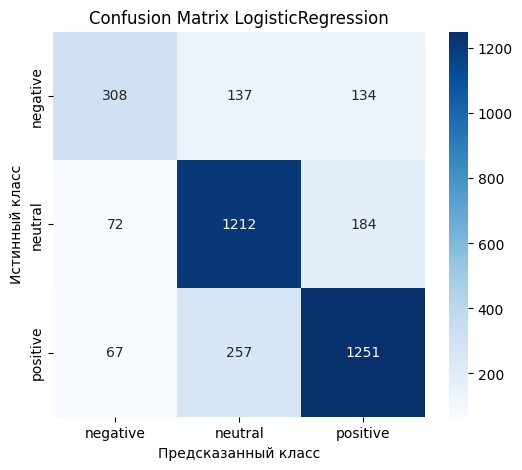

              precision    recall  f1-score   support

    negative       0.69      0.53      0.60       579
     neutral       0.75      0.83      0.79      1468
    positive       0.80      0.79      0.80      1575

    accuracy                           0.77      3622
   macro avg       0.75      0.72      0.73      3622
weighted avg       0.76      0.77      0.76      3622



In [16]:


cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=clf_lr.classes_, yticklabels=clf_lr.classes_)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Confusion Matrix LogisticRegression')
plt.show()

print(classification_report(y_test, y_pred_lr))

In [25]:
errors_lr = pd.DataFrame({
    "text": X_test,
    "true": y_test,
    "pred": y_pred_lr
})
errors_lr = errors_lr[errors_lr["true"] != errors_lr["pred"]]

for i, row in errors_lr.head(10).iterrows():
    print(f"Текст: {row['text']}\nИстинный класс: {row['true']}\nПредсказанный класс: {row['pred']}")
    # Анализ вклада слов
    vec = vectorizer_lr.transform([row['text']])
    feature_names = vectorizer_lr.get_feature_names_out()
    # Получаем коэффициенты для предсказанного класса
    coefs = clf_lr.coef_[clf_lr.classes_ == row['pred']][0]
    word_contrib = vec.toarray()[0] * coefs
    top_words_idx = word_contrib.argsort()[::-1][:5]
    print("Топ-5 слов по вкладу в ошибку:")
    for idx in top_words_idx:
        if vec.toarray()[0][idx] > 0:
            print(f"  {feature_names[idx]}: {word_contrib[idx]:.4f}")
    print()

Текст: прогноз комментарий понедельник рост акция общий фон российский рынок акция оставаться стабильный шанс продолжение трендового подъём подробность читать утренний обзор
Истинный класс: neutral
Предсказанный класс: positive
Топ-5 слов по вкладу в ошибку:
  рост: 0.6500
  стабильный: 0.3435
  подъём: 0.3080
  шанс: 0.2625
  подробность: 0.1314

Текст: yndx яндекс работать устранение сбой работа сервис компания пользователь жаловаться сбой работа поиск карта кинопоиска музыка маркет
Истинный класс: negative
Предсказанный класс: positive
Топ-5 слов по вкладу в ошибку:
  карта: 0.4101
  пользователь: 0.3013
  музыка: 0.2803
  компания: 0.2539
  сервис: 0.2292

Текст: bspb банк санкт петербург судиться euroclear бельгия выиграть ведомость попадание санкция сша банк получить часть заблокировать средство
Истинный класс: negative
Предсказанный класс: neutral
Топ-5 слов по вкладу в ошибку:
  ведомость: 0.3942
  bspb: 0.1834
  средство: 0.1487
  петербург: 0.1481
  банк: 0.1163

Текст: ситуа

Модель часто путает классы, связанные с позитивными и нейтральными новостями. Например, нейтральные тексты с упоминанием "рост", "стабильный", "подъём" модель относит к позитивным, потому что эти слова имеют высокий положительный вклад.

Слова, связанные с негативом ("не", "дефицит", "смерть", "заболеваемость"), могут приводить к ошибочной классификации в негативный класс, даже если общий контекст позитивный или нейтральный.

Важные тематические слова ("санкция", "вырасти", "снизиться", "сократиться") сильно влияют на решение модели. Если они часто встречаются в определённом классе, модель склонна относить текст к этому классу, даже если контекст иной.

Ошибки часто связаны с тем, что модель не учитывает сложные контексты и взаимодействие между словами — она опирается на индивидуальные веса слов.

# 8. Теперь очеред за RandomForest

Тепловая карта матрицы ошибок и classification report для RandomForest.

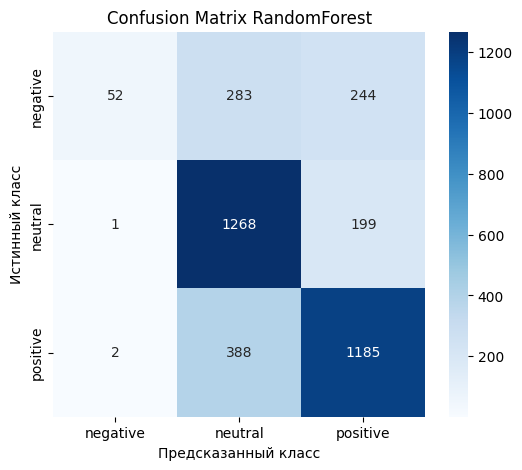

              precision    recall  f1-score   support

    negative       0.95      0.09      0.16       579
     neutral       0.65      0.86      0.74      1468
    positive       0.73      0.75      0.74      1575

    accuracy                           0.69      3622
   macro avg       0.78      0.57      0.55      3622
weighted avg       0.73      0.69      0.65      3622



In [19]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=clf_rf.classes_, yticklabels=clf_rf.classes_)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Confusion Matrix RandomForest')
plt.show()

print(classification_report(y_test, y_pred_rf))

Модель практически не распознаёт негативные тексты: recall для negative — всего 0.09, то есть из всех негативных примеров правильно определяет только ~9%. Это говорит о сильном перекосе в сторону других классов.

Для классов neutral и positive показатели recall и f1-score значительно выше (0.86/0.74 и 0.75/0.74 соответственно), то есть модель хорошо различает нейтральные и позитивные новости.

Основная проблема — недостаточное количество негативных примеров в обучающей выборке и склонность модели игнорировать этот класс.

Либо модель добрая

In [26]:
errors_rf = pd.DataFrame({
    "text": X_test,
    "true": y_test,
    "pred": y_pred_rf
})

errors_rf = errors_rf[errors_rf["true"] != errors_rf["pred"]]

for i, row in errors_rf.head(10).iterrows():
    print(f"Текст: {row['text']}\nИстинный класс: {row['true']}\nПредсказанный класс: {row['pred']}\n")
    # Анализ вклада слов через feature_importances_
    vec = vectorizer_rf.transform([row['text']])
    feature_names = vectorizer_rf.get_feature_names_out()
    # Получаем средние важности признаков по всем деревьям
    importances = clf_rf.feature_importances_
    word_contrib = vec.toarray()[0] * importances
    top_words_idx = word_contrib.argsort()[::-1][:5]
    print("Топ-5 слов по вкладу в ошибку:")
    for idx in top_words_idx:
        if vec.toarray()[0][idx] > 0:
            print(f"  {feature_names[idx]}: {word_contrib[idx]:.4f}")
    print()

Текст: прогноз комментарий понедельник рост акция общий фон российский рынок акция оставаться стабильный шанс продолжение трендового подъём подробность читать утренний обзор
Истинный класс: neutral
Предсказанный класс: positive

Топ-5 слов по вкладу в ошибку:
  рост: 0.0053
  акция: 0.0010
  фон: 0.0008
  прогноз: 0.0007
  рынок: 0.0005

Текст: yndx яндекс работать устранение сбой работа сервис компания пользователь жаловаться сбой работа поиск карта кинопоиска музыка маркет
Истинный класс: negative
Предсказанный класс: neutral

Топ-5 слов по вкладу в ошибку:
  компания: 0.0013
  карта: 0.0003
  работа: 0.0001
  яндекс: 0.0001
  работать: 0.0001

Текст: uwgn дискретный аукцион акция овк третий день подряд upd первый два день акция падать сегодня рост
Истинный класс: negative
Предсказанный класс: positive

Топ-5 слов по вкладу в ошибку:
  рост: 0.0062
  падать: 0.0013
  акция: 0.0012
  день: 0.0009
  сегодня: 0.0004

Текст: bspb банк санкт петербург судиться euroclear бельгия выиграть в

Вклады слов очень малы — значения вкладов (word_contrib) порядка тысячных, что говорит о слабом влиянии отдельных слов на итоговое решение. Это типично для RandomForest, где важность признаков усредняется по деревьям и редко бывает высокой для одного слова.

Ошибки связаны с тем, что модель не выделяет "маркерные" слова для классов. Например, слова "рост", "акция", "рынок" встречаются в нейтральных и позитивных текстах, но не дают сильного сигнала для правильной классификации.

Модель путает классы, если в тексте много общих для всех классов слов — например, "компания", "работа", "банк", "год", "цена" встречаются в разных классах и не дают однозначного сигнала.

Я верил в него до последнего, а он ... не смог

# 9. Посмотрим что будет если нагенерировать новости

In [ ]:
# Чат выдал вот такие предложения с метками
examples = [
    "ЦБ повысил ключевую ставку до 16%.",
    "Акции Газпрома выросли на фоне позитивных новостей.",
    "Рубль резко ослаб на торгах в понедельник.",
    "ВТБ объявил о рекордной прибыли за квартал.",
    "Инвесторы опасаются новых санкций против России."
]
example_labels = ["neutral", "positive", "negative", "positive", "negative"]


# Предобработаем
examples_preprocessed = [preprocess(text) for text in examples]

# Векторизация и предсказание
examples_vec_lr = vectorizer_lr.transform(examples_preprocessed)
preds_lr = clf_lr.predict(examples_vec_lr)
examples_vec_rf = vectorizer_rf.transform(examples_preprocessed)
preds_rf = clf_rf.predict(examples_vec_rf)

# Вывод результатов
for i, text in enumerate(examples):
    print(f"Текст: {text}")
    print(f"Истинная метка: {example_labels[i]}")
    print(f"LogisticRegression: {preds_lr[i]}")
    print(f"RandomForest: {preds_rf[i]}\n")

Текст: ЦБ повысил ключевую ставку до 16%.
Истинная метка: neutral
LogisticRegression: positive
RandomForest: neutral

Текст: Акции Газпрома выросли на фоне позитивных новостей.
Истинная метка: positive
LogisticRegression: positive
RandomForest: positive

Текст: Рубль резко ослаб на торгах в понедельник.
Истинная метка: negative
LogisticRegression: negative
RandomForest: neutral

Текст: ВТБ объявил о рекордной прибыли за квартал.
Истинная метка: positive
LogisticRegression: positive
RandomForest: positive

Текст: Инвесторы опасаются новых санкций против России.
Истинная метка: negative
LogisticRegression: negative
RandomForest: neutral



В целом тоже самое что и при тесте, LogisticRegression неплохо справляется, RandomForest опять плох с негативным классом